In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
# from tqdm.autonotebook import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pathlib
import seaborn as sns

from scipy.stats import linregress, gaussian_kde

import skgstat as skg
from pylr2 import regress2


### 1. Read in data

In [2]:
df = pd.read_feather('/maps/forecol/data/Overlays/monte_carlo_no_spatial_autocorr/results/std1/master_summary.feather')

l4a_data = df
l4a_data['agcd'] = l4a_data.agbd * 0.47
l4a_data['recovery_period'] = l4a_data.mode_vals
quality_gedi = l4a_data

In [85]:
quality_gedi_gdf = gpd.GeoDataFrame(quality_gedi, geometry=gpd.points_from_xy(quality_gedi.lon_lowestmode, quality_gedi.lat_lowestmode))

### 2. Basic data filtering

29203


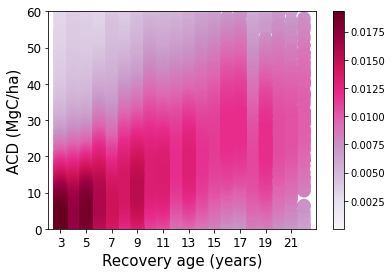

In [91]:
qg = quality_gedi

n = len(qg)
print(n)
# sample = np.random.choice(n, size=int(n/5), replace=False)
# x = qg.recovery_period.iloc[sample].values
# y = qg.agbd.iloc[sample].values

x = qg.recovery_period.values
y = qg.agcd.values

# Calculate the point density distribution per age group
ages = np.unique(x)
z = np.zeros(y.shape)
for i in ages:
    z[x == i] = gaussian_kde(y[x == i])(y[x == i])


# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

# limit to only the points with high enough density
# x = x[z > 0.005]
# y = y[z > 0.005]
# z = z[z > 0.005]

fig, ax = plt.subplots()
im = ax.scatter(x, y, c=z, s=150, cmap='PuRd')
ax.set_ylim([0,60])
ax.set_xticks(ages[::2])
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel("Recovery age (years)", size=15)
ax.set_ylabel("ACD (MgC/ha)", size=15)
plt.colorbar(im)

plt.show()



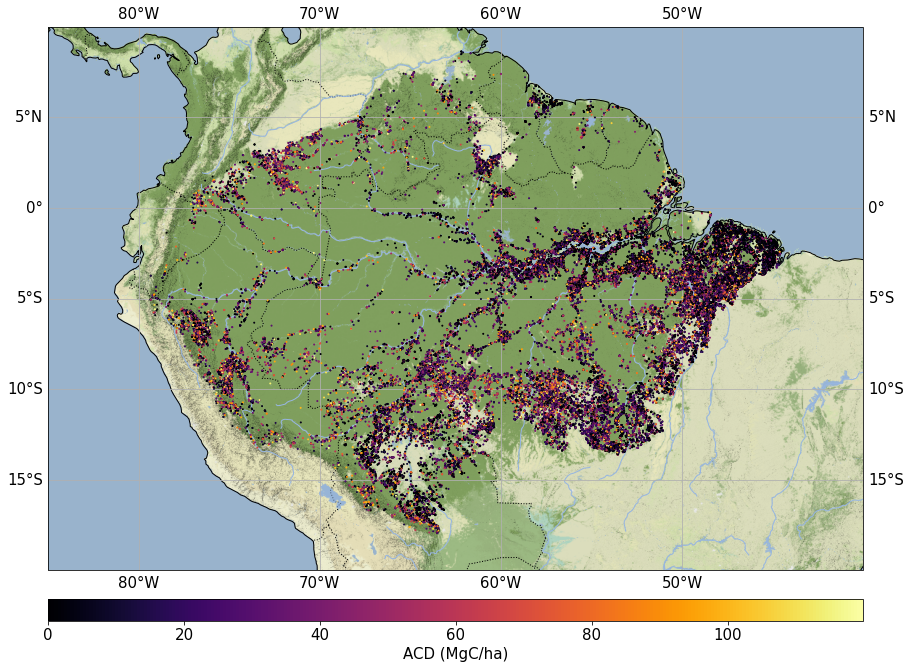

In [77]:

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-85, -40, -20, 10], crs=ccrs.PlateCarree())

# Background: Stamen terrain with added Cartopy features
stamen_terrain = cimgt.Stamen('terrain-background')
ax.add_image(stamen_terrain, 8)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Add the colorbar axes anywhere in the figure. Its position will be
# re-calculated after the main plot is drawn
cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])
cbar_orientation = "horizontal"
cbar_width = 0.03

# Plot our data
not_outliers = quality_gedi_gdf[(quality_gedi_gdf.agcd < 120)]
not_outliers.plot(column='agcd', zorder=10, markersize=1, ax=ax, cmap='inferno', legend=True, legend_kwds={"orientation": cbar_orientation, "label": "ACD (MgC/ha)"}, cax=cbar_ax)

## Find the location of the main plot axes now that the plot has been drawn, and stick our colorbar there.
posn = ax.get_position()
if cbar_orientation == "vertical":
    cbar_ax.set_position([posn.x0+posn.width+0.05, posn.y0, cbar_width, posn.height])
    cbar_ax.tick_params(axis="y", which="major", labelsize=15)
    cbar_ax.yaxis.label.set_size(15)
if cbar_orientation == "horizontal":
    cbar_ax.set_position([posn.x0, posn.y0-0.07, posn.width, cbar_width])
    cbar_ax.tick_params(axis="x", which="major", labelsize=15)
    cbar_ax.xaxis.label.set_size(15)

# Longitude and latitude degrees on the axes
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}

plt.show()



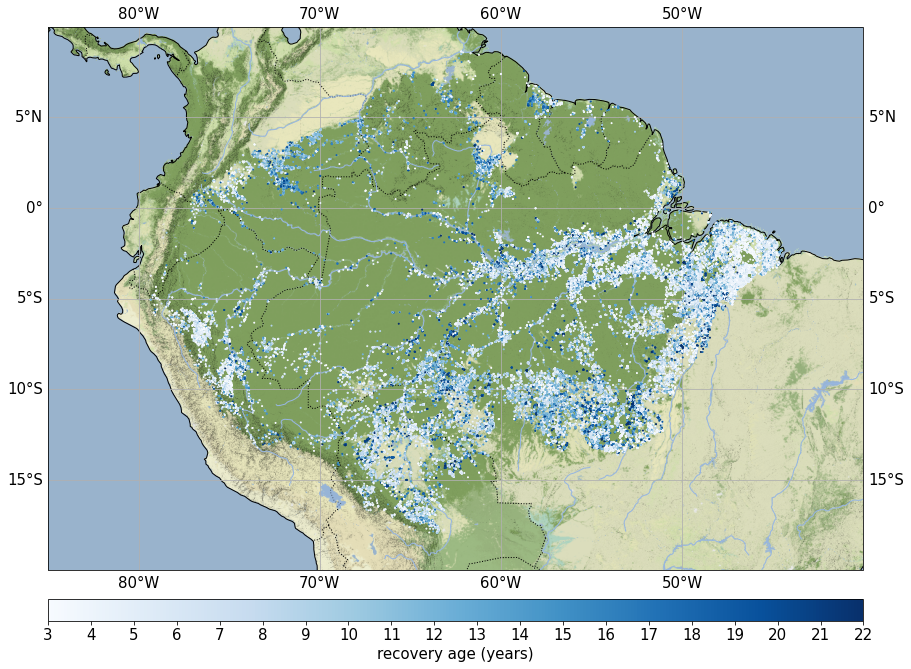

In [78]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-85, -40, -20, 10], crs=ccrs.PlateCarree())

# Background: Stamen terrain with added Cartopy features
stamen_terrain = cimgt.Stamen('terrain-background')
ax.add_image(stamen_terrain, 8)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Add the colorbar axes anywhere in the figure. Its position will be
# re-calculated after the main plot is drawn
cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])
cbar_orientation = "horizontal"
cbar_width = 0.03

# Plot our data
not_outliers = quality_gedi_gdf[quality_gedi_gdf.agcd < 120]
max_age = int(not_outliers.recovery_period.max())
not_outliers.plot(
    column='recovery_period', zorder=10, markersize=1, ax=ax, cmap='Blues', 
    legend=True, legend_kwds={
        "orientation": cbar_orientation, 
        "label": "recovery age (years)", 
        "ticks": list(range(max_age + 1))
    }, cax=cbar_ax
)

## Find the location of the main plot axes now that the plot has been drawn, and stick our colorbar there.
posn = ax.get_position()
if cbar_orientation == "vertical":
    cbar_ax.set_position([posn.x0+posn.width+0.05, posn.y0, cbar_width, posn.height])
    cbar_ax.tick_params(axis="y", which="major", labelsize=15)
    cbar_ax.yaxis.label.set_size(15)
if cbar_orientation == "horizontal":
    cbar_ax.set_position([posn.x0, posn.y0-0.07, posn.width, cbar_width])
    cbar_ax.tick_params(axis="x", which="major", labelsize=15)
    cbar_ax.xaxis.label.set_size(15)

# Longitude and latitude degrees on the axes
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}

plt.show()

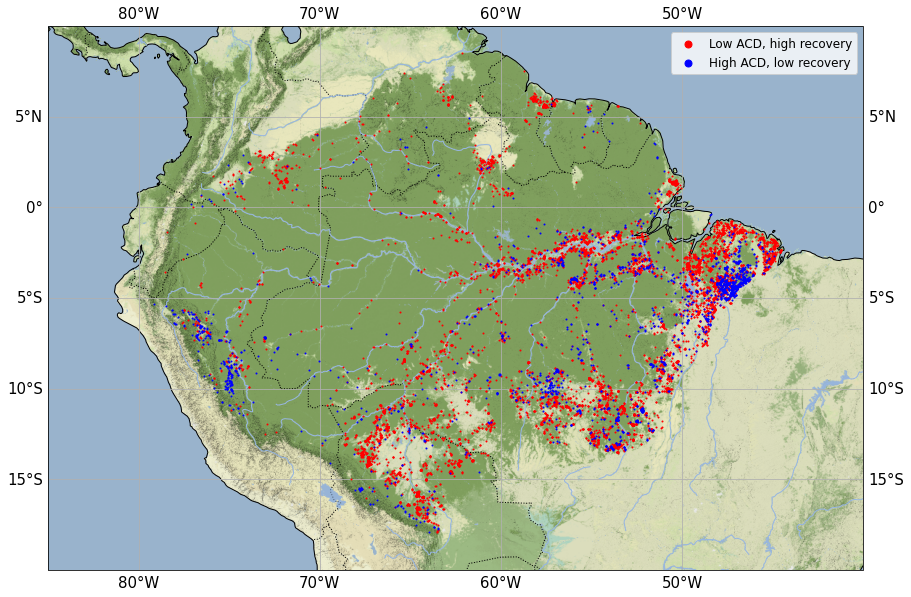

In [79]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-85, -40, -20, 10], crs=ccrs.PlateCarree())

# Background: Stamen terrain with added Cartopy features
stamen_terrain = cimgt.Stamen('terrain-background')
ax.add_image(stamen_terrain, 8)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Plot our data
low = quality_gedi_gdf[(quality_gedi_gdf.agcd < 1) & (quality_gedi_gdf.recovery_period > 5)]
high = quality_gedi_gdf[(quality_gedi_gdf.agcd > 100) & (quality_gedi_gdf.recovery_period < 4)]
low.plot(color="red", zorder=10, markersize=1, ax=ax)
high.plot(color="blue", zorder=10, markersize=1, ax=ax)

# Longitude and latitude degrees on the axes
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}

plt.legend(["Low ACD, high recovery", "High ACD, low recovery"], loc=0, frameon=True, fontsize="large", markerscale=7)

plt.show()

In [80]:
low_count = len(quality_gedi[(quality_gedi.agcd < 1) & (quality_gedi.recovery_period > 5)])
low_pct = low_count/len(quality_gedi)

high_count = len(quality_gedi[(quality_gedi.agcd > 100) & (quality_gedi.recovery_period < 4)])
high_pct = high_count / len(quality_gedi)

print("Unlikely zeros:")
print("{} ({} %)".format(low_count, low_pct))
print("Unlikely extreme highs:")
print("{} ({} %)".format(high_count, high_pct))

Unlikely zeros:
8535 (0.07466015850522227 %)
Unlikely extreme highs:
2408 (0.021064049406042794 %)


### 3a. Modeling: Quantile Regression

In [3]:
# qreg_params = pd.read_feather('/maps/forecol/data/Overlays/monte_carlo/model_results_pctnonan=100_.feather')
qreg_params = pd.read_feather('/maps/forecol/data/Overlays/monte_carlo/model_results_pctnonan=100_maxstd=1_.feather')
# qreg_params = pd.read_feather('/maps/forecol/data/Overlays/monte_carlo/model_results_pctnonan=100_maxstd=0_.feather')

### 3b. Modeling: Linear Regression

### 4. Graphs

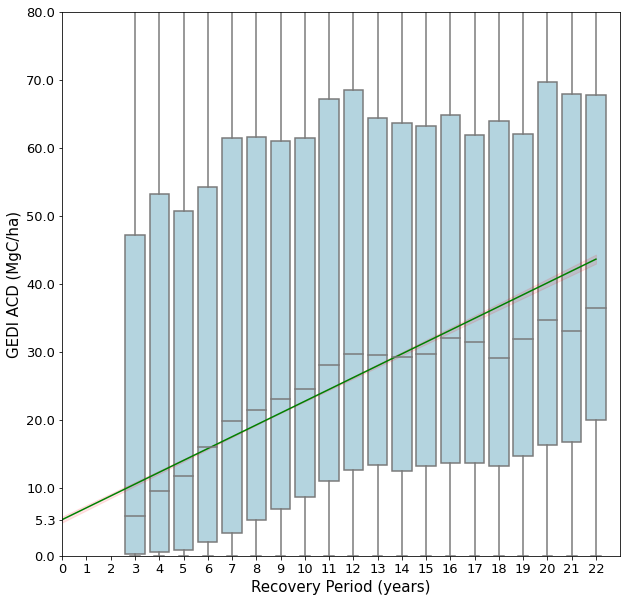

In [4]:
plt.figure(1, (10,10))
ax = sns.boxplot(x="recovery_period", y="agcd", data=quality_gedi, color='lightblue', showfliers=False, order=np.arange(23))
ax.set_ylabel("GEDI ACD (MgC/ha)", fontsize=15)
ax.set_xlabel("Recovery Period (years)", fontsize=15)
ax.set_xlim([0,23])
xs = np.arange(0, 23)

# cmap = plt.get_cmap('inferno')
get_ys = lambda a, b: a + b * xs
# for i in range(0,models.shape[0], 10):
#     ys = get_ys(models.a[i], models.b[i])
#     ax.plot(xs, ys, linestyle="dotted", color=cmap(i), label='Quantile {0:.2f}'.format(models.q[i]))
def get_ys_ci(la, lb, ua, ub):
    return (la + ub * xs, ua + lb * xs)


med_ys = get_ys(qreg_params.b0.mean(), qreg_params.b1.mean())
lower_ys, upper_ys = get_ys_ci(qreg_params.b0.quantile(0.025), qreg_params.b1.quantile(0.025), qreg_params.b0.quantile(0.975), qreg_params.b1.quantile(0.975))
ax.plot(xs, med_ys, color="green")
# ci_lines = qreg_params.sample(100)
# for line in ci_lines.iterrows():
#     ax.plot(xs, get_ys(line[1].b0, line[1].b1), color="green", alpha=0.1)
ax.fill_between(xs, lower_ys, upper_ys, color="red", alpha=0.1)

ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
ax.set_ylim([0, 80])
yticks = list(ax.get_yticks()[ax.get_yticks() >= 0])
yticks.append(qreg_params.b0.mean())
yticks.sort()
ax.set_yticks(yticks)
ax.tick_params(axis='both', which='major', labelsize=13)

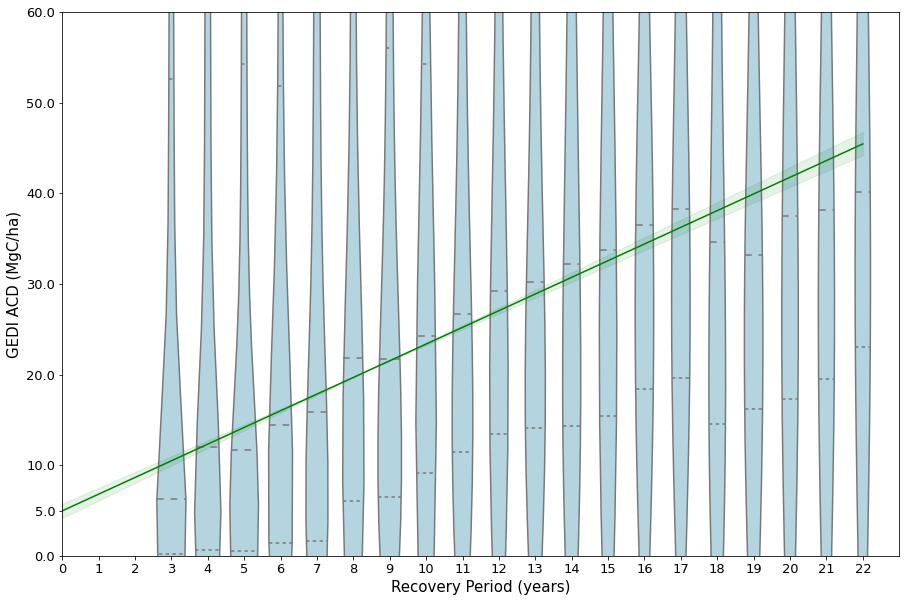

In [98]:
plt.figure(1, (15,10))
ax = sns.violinplot(x="recovery_period", y="agcd", data=quality_gedi, color="lightblue", inner="quartile", order=np.arange(23))
ax.set_ylabel("GEDI ACD (MgC/ha)", fontsize=15)
ax.set_xlabel("Recovery Period (years)", fontsize=15)
ax.set_xlim([0,23])

xs = np.arange(0, 23)

# cmap = plt.get_cmap('inferno')
get_ys = lambda a, b: a + b * xs
# for i in range(0,models.shape[0], 10):
#     ys = get_ys(models.a[i], models.b[i])
#     ax.plot(xs, ys, linestyle="dotted", color=cmap(i), label='Quantile {0:.2f}'.format(models.q[i]))
def get_ys_ci(la, lb, ua, ub):
    return (la + ub * xs, ua + lb * xs)


med_ys = get_ys(qreg_params.b0.mean(), qreg_params.b1.mean())
lower_ys, upper_ys = get_ys_ci(qreg_params.b0.quantile(0.025), qreg_params.b1.quantile(0.025), qreg_params.b0.quantile(0.975), qreg_params.b1.quantile(0.975))
ax.plot(xs, med_ys, color="green")
# ci_lines = qreg_params.sample(100)
# for line in ci_lines.iterrows():
#     ax.plot(xs, get_ys(line[1].b0, line[1].b1), color="green", alpha=0.1)
ax.fill_between(xs, lower_ys, upper_ys, color="green", alpha=0.1)

ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
ax.set_ylim([0, 60])
yticks = list(ax.get_yticks()[ax.get_yticks() >= 0])
yticks.append(qreg_params.b0.mean())
yticks.sort()
ax.set_yticks(yticks)
ax.tick_params(axis='both', which='major', labelsize=13)

29203


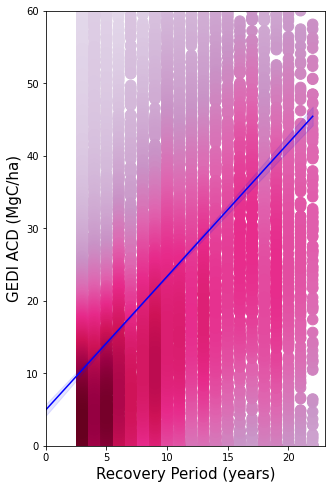

In [52]:
fig, ax = plt.subplots(1, figsize=(5,8))

qg = quality_gedi
n = len(qg)
print(n)
# sample = np.random.choice(n, size=int(n/5), replace=False)
# x = qg.recovery_period.iloc[sample].values
# y = qg.agbd.iloc[sample].values

x = qg.recovery_period.values
y = qg.agcd.values

# Calculate the point density distribution per age group
ages = np.unique(x)
z = np.zeros(y.shape)
for i in ages:
    z[x == i] = gaussian_kde(y[x == i])(y[x == i])


# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

# limit to only the points with high enough density
# x = x[z > 0.005]
# y = y[z > 0.005]
# z = z[z > 0.005]

ax.scatter(x, y, c=z, s=110, cmap='PuRd')
ax.set_ylim([0,60])

xs = np.arange(0, 23)
get_ys = lambda a, b: a + b * xs
def get_ys_ci(la, lb, ua, ub):
    return (la + ub * xs, ua + lb * xs)
    
med_ys = get_ys(qreg_params.b0.mean(), qreg_params.b1.mean())
lower_ys, upper_ys = get_ys_ci(qreg_params.b0.quantile(0.025), qreg_params.b1.quantile(0.025), qreg_params.b0.quantile(0.975), qreg_params.b1.quantile(0.975))
ax.plot(xs, med_ys, color="blue")
ax.fill_between(xs, lower_ys, upper_ys, color="blue", alpha=0.1)
ax.set_ylabel("GEDI ACD (MgC/ha)", fontsize=15)
ax.set_xlabel("Recovery Period (years)", fontsize=15)
ax.set_xlim([0,23])
plt.show()

### 5. Cross-validation

In [24]:
# K-fold cross-validation for the median quantile regression line
# Returns array of error results on each split.

def check_function(q, ys, predictions):
    abs_err = (ys - predictions).abs()
    penalty_under = (q * abs_err[predictions <= ys]).sum()
    penalty_over = ((1 - q) * abs_err[predictions > ys]).sum()
    return (penalty_under + penalty_over) / len(ys)

def compute_qreg_error(model, q, data, predictor, response):
    a = qreg_params.b0.mean()
    b = qreg_params.b1.mean()
    predictions = a + b * data[predictor]
    return check_function(q, data[response], predictions) 


def cross_validate_qregression(
    q: float, n_splits: int, data: pd.DataFrame, predictor: str, response: str):
    kf = KFold(n_splits=n_splits, shuffle=True)
    qregs = []
    for train_index, test_index in kf.split(data):
        train = data.iloc[train_index].loc[:, [predictor, response]]
        test =  data.iloc[test_index][[predictor, response]]

        mod = smf.quantreg(response + ' ~ ' + predictor, train)
        model = mod.fit(q=q)

        qregs.append(compute_qreg_error(model, q, test, predictor, response))

    return np.array(qregs)

In [27]:
qregs = cross_validate_qregression(
    q=0.36,
    n_splits=10,
    data=quality_gedi,
    predictor='recovery_period',
    response='agcd'
)
print(qregs)
print(qregs.mean())


[15.42950159 15.08022283 15.39676996 15.07112365 15.756576   15.55263866
 15.42889689 15.71436642 15.36779398 14.96040177]
15.375829175343355


In [39]:
# Add column of residuals to dataframe
q=0.5
mod = smf.quantreg('agcd ~ recovery_period', quality_gedi)
median_model = mod.fit(q=q)

predictions = median_model.params['Intercept'] + median_model.params['recovery_period'] * quality_gedi['recovery_period']
quality_gedi['median_error'] = predictions - quality_gedi['agcd']

abs_err = quality_gedi.median_error.abs()
quality_gedi['median_qreg_error'] = np.zeros_like(abs_err)
quality_gedi.loc[quality_gedi.median_error <= 0, 'median_qreg_error']  = q * abs_err[quality_gedi.median_error <= 0]
quality_gedi.loc[quality_gedi.median_error > 0, 'median_qreg_error'] = (1 - q) * abs_err[quality_gedi.median_error > 0]

/tmp/ipykernel_3344467/383683554.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quality_gedi['median_error'] = predictions - quality_gedi['agcd']
/tmp/ipykernel_3344467/383683554.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quality_gedi['median_qreg_error'] = np.zeros_like(abs_err)


count    9.634800e+04
mean    -8.245183e+00
std      2.856587e+01
min     -1.281676e+03
25%     -1.567212e+01
50%     -9.939261e-07
75%      6.622826e+00
max      3.381453e+01
Name: median_error, dtype: float64
count    96348.000000
mean         8.215980
std         12.389316
min          0.000001
25%          2.500680
50%          4.408315
75%          9.414916
max        640.837917
Name: median_qreg_error, dtype: float64


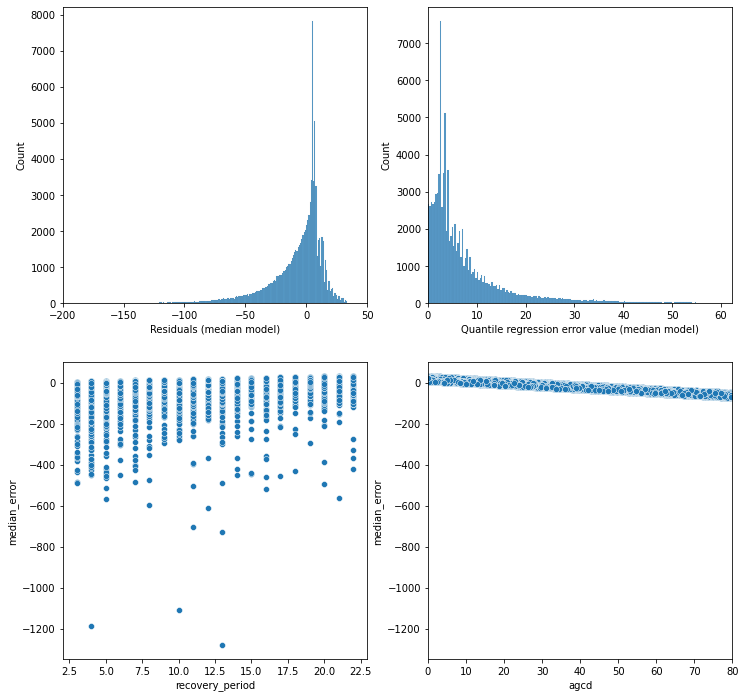

In [15]:
# Plot model residuals (histogram)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
sns.histplot(quality_gedi, x='median_error', ax=axs[0, 0])
axs[0, 0].set_xlim(-200, 50)
axs[0, 0].set_xlabel('Residuals (median model)')
sns.histplot(quality_gedi, x='median_qreg_error', ax=axs[0, 1])
axs[0, 1].set_xlim(0, 8.2 + 12.3 * 4.4)
axs[0, 1].set_xlabel('Quantile regression error value (median model)')
sns.scatterplot(data=quality_gedi, x='recovery_period', y='median_error', ax=axs[1,0])
sns.scatterplot(data=quality_gedi, x='agcd', y='median_error', ax=axs[1,1])
axs[1,1].set_xlim(0,80)
print(quality_gedi.median_error.describe())
print(quality_gedi.median_qreg_error.describe())


### 6. Spatial (Auto)correlation

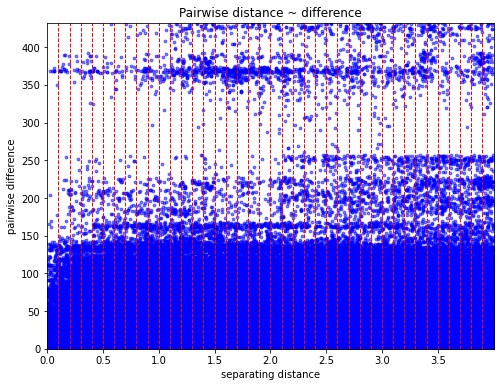

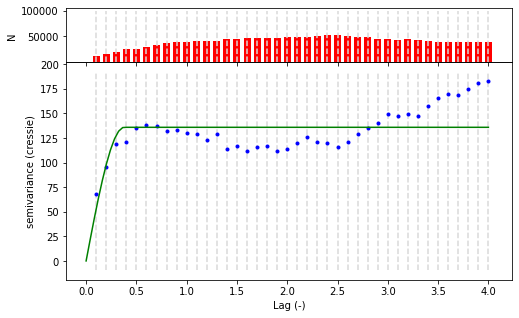

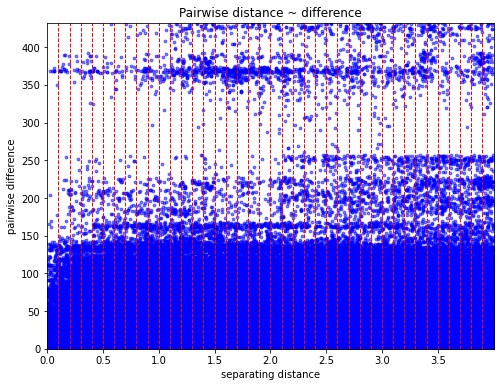

In [9]:
# Plot variogram based on residuals

# Sample a random selection of data points
k = 20      # Randomly sample 1/k th of the points
np.random.seed(42)
idxs = np.random.randint(0, len(quality_gedi), (int(len(quality_gedi) / k)))
coords = quality_gedi.iloc[idxs][['lon_lowestmode', 'lat_lowestmode']].to_numpy()
values = quality_gedi.iloc[idxs]['median_error'].abs().to_numpy()
V = skg.Variogram(
    coords,         # Spatial coordinates
    values,         # Residuals
    maxlag=40,       # Maximum distance (in lon,lat units) between data points to consider
    n_lags=40,
)
V.estimator = 'cressie'
V.plot()
V.distance_difference_plot()

### Other ...

In [18]:
tot = len(l4a_data)
lst = []
lst.append(len(l4a_data[l4a_data.overlap_quality != 0]))
lst.append(len(l4a_data[(l4a_data.recovery_period >= 3) & (l4a_data.recovery_period <= 22)]))
lst.append(len(l4a_data[l4a_data.l4_quality_flag == 1]))
lst.append(len(l4a_data[l4a_data.l2_quality_flag == 1]))
lst.append(len(l4a_data[l4a_data.degrade_flag == 0]))

for el in lst:
    print(f"{el}: {el/tot * 100}%")

print(tot)
a = len(quality_gedi[quality_gedi.agbd < 99])
print(f"{a}: {a/len(quality_gedi) * 100}%")


626313: 28.48826128783554%
1794028: 81.60255083591275%
1630945: 74.18461265547568%
1987172: 90.38783349518647%
1672236: 76.06276111612716%
2198495
84805: 88.01947108398721%


801
28
(-0.001, 1.0]     61
(1.0, 2.0]         6
(2.0, 3.0]        11
(3.0, 4.0]         9
(4.0, 5.0]         3
(5.0, 400.0]     710
Name: agcd, dtype: int64


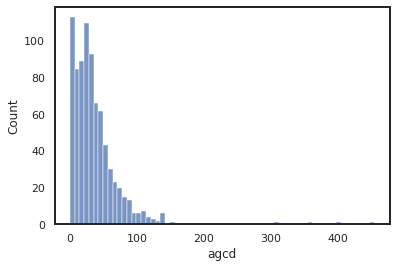

In [19]:
sns.histplot(quality_gedi[quality_gedi.recovery_period == 22], x='agcd')

yr_22 = quality_gedi[quality_gedi.recovery_period == 22]

print(len(yr_22))
print(len(yr_22[yr_22.agcd == 0]))
bins = [0,1,2,3,4,5,400]
print(yr_22['agcd'].value_counts(bins=bins, sort=False))